<a href="https://colab.research.google.com/github/sidchaini/dimmadtutorial/blob/main/tutorial_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![github-badge](https://img.shields.io/badge/GitHub-sidchaini/dimmadtutorial-blue)](https://github.com/sidchaini/dimmadtutorial)

# Distance Multi-Metric Anomaly Detection
Author: Siddharth Chaini

4 February 2026 (Prepared for [Quasar Bazaar Hackweek](https://indico.sissa.it/event/178/))

## 0. Installing DistClassiPy
- The anomaly detector is now included in DistClassiPy

In [1]:
# !pip install distclassipy

In [2]:
import distclassipy as dcpy

print(dcpy.__version__)

0.2.3


## 1. Other imports and preamble

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from distclassipy.anomaly import DistanceAnomaly
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

sns.set_theme(context="talk", style="whitegrid", palette="tab10")
%matplotlib inline

seed_val = 44
np.random.seed(seed_val)

## 2. Let us use features derived from ZTF by ALeRCE 
These features were extracted by the [ALeRCE team](https://science.alerce.online/) from the Zwicky Transient Facility light curves using their pipeline [(Sánchez-Sáez+21)](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract) and their [GitHub](https://github.com/alercebroker/pipeline).

Note: We'll download this as a parquet file from the [DiMMAD paper](https://ml4physicalsciences.github.io/2025/files/NeurIPS_ML4PS_2025_222.pdf) directory.

In [4]:
url = "https://github.com/sidchaini/DiMMAD/raw/refs/heads/main/data/alerceztf_features.parquet"

df = pd.read_parquet(url)
df.head(5)

,gal_b,gal_l,g-r_max,g-r_mean,g-r_max_corr,g-r_mean_corr,rb,MHPS_ratio_1,MHPS_low_1,MHPS_high_1,...,hierPred_without_LPV,hierPred_without_SLSN,hierPred_without_SNII,hierPred_without_SNIa,hierPred_without_SNIbc,hierPred_without_AGN,hierPred_without_Blazar,hierPred_without_CV/Nova,hierPred_without_QSO,hierPred_without_YSO
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aabbiaa,-25.866222,215.716217,-0.060185,-0.064353,0.028530,0.377175,0.920000,4.524069,1.909262,0.422023,...,None,None,None,None,None,None,None,None,None,None
ZTF18abaqokb,2.823396,88.147499,3.649449,3.434238,4.305536,4.270406,0.745714,6.754300,0.022092,0.003271,...,None,None,None,None,None,None,None,None,None,None
ZTF17aadpsmy,-32.951927,178.347549,0.547729,0.597868,0.502165,0.537727,0.881429,6.514539,0.293780,0.045096,...,None,None,None,None,None,None,None,None,None,None
ZTF19adccquo,58.401688,185.347183,0.160484,0.080856,0.080016,0.051497,0.877143,5.098246,0.032027,0.006282,...,None,None,None,None,None,None,None,None,None,None
ZTF17aabxogq,74.315201,118.067085,-0.424945,0.050323,-0.087608,0.231141,0.843333,0.965851,0.534262,0.553151,...,None,None,None,None,None,None,None,None,None,None


In [5]:
print(f"Total objects: {len(df)}")
print(f"Classes found: {df['class'].unique()}")

Total objects: 116351
Classes found: ['RRL' 'LPV' 'E' 'QSO' 'YSO' 'SNIa' 'AGN' 'CEP' 'Periodic-Other' 'DSCT'
 'Blazar' 'SNII' 'CV/Nova' 'SLSN' 'SNIbc']


## 3. Knowns, and Unknowns

Let us consider an alternate universe: a world where we know a few classes of supernovae are well known, but QSOs or AGNs have not been discovered and are ```unknown``` to us.

So, we will train our algorithm(s) on objects belonging only to the known classes. And hide the unknowns in between a new set of hidden knowns, and see if our algorithm can recover these objects from the  as anomalies.

In [6]:
known_classes = ["SNIa", "SNII", "SLSN", "SNIbc"]
unknown_classes = ["QSO", "AGN"]

In [7]:
features_to_use = [c for c in df.columns if c.startswith("SPM")]
# features_to_use

In [8]:
df_subset = (
    df[df["class"].isin(known_classes + unknown_classes)][features_to_use + ["class"]]
    .dropna()
    .copy()
)

In [9]:
# knowns

df_known = df_subset[df_subset["class"].isin(known_classes)].dropna()
X_known = df_known[features_to_use].values
y_known = df_known["class"].values

In [10]:
# unknowns

df_unknown = (
    df_subset[df_subset["class"].isin(unknown_classes)]
    .dropna()
    .sample(100, random_state=seed_val)
)
X_unknown = df_unknown[features_to_use].values
y_unknown = df_unknown["class"].values

In [11]:
# train = knowns

X_train, X_test_inliers, y_train, y_test_inliers = train_test_split(
    X_known, y_known, test_size=0.3, stratify=y_known, random_state=seed_val
)

In [12]:
# test = knowns + unknowns

X_test = np.vstack([X_test_inliers, X_unknown])
y_test = np.concatenate([y_test_inliers, y_unknown])


y_test_binary = np.isin(y_test, unknown_classes).astype(int)  # label for anom

In [13]:
print(f"Training Size: {len(X_train)} (All Knowns)")
print(
    f"Test Size: {len(X_test)} ({np.sum(y_test_binary)} unknowns + {(y_test_binary==0).sum()} knowns)"
)

Training Size: 1905 (All Knowns)
Test Size: 917 (100 unknowns + 817 knowns)


## 4. Using DistanceAnomaly

In [14]:
model = DistanceAnomaly(cluster_agg="min", metric_agg="median")
# cluster_agg='min': Distance to the nearest class centroid
# metric_agg='median': Consensus across the 16 distance metrics

In [15]:
print("Training DiMMAD...")
model.fit(X_train, y_train)
print("Done!")

scores = model.decision_function(X_test)
# higher is more anomalous

Training DiMMAD...
Done!


## 5. Some quick checks on the results

### 5.1. What are the most anomalous objects?

In [16]:
results = pd.DataFrame(
    {"True_Class": y_test, "Is_Anomaly": y_test_binary, "Anomaly_Score": scores}
)

results = results.sort_values("Anomaly_Score", ascending=False)
# most anomalous as the top

results.head(10)

,True_Class,Is_Anomaly,Anomaly_Score
227,SNIa,0,0.978433
856,QSO,1,0.803288
889,QSO,1,0.798801
843,QSO,1,0.798644
873,QSO,1,0.795545
890,QSO,1,0.794257
863,QSO,1,0.793684
910,AGN,1,0.789968
914,QSO,1,0.787163
841,AGN,1,0.786806


### 5.2. Do anomalous objects have high anomalous scores?

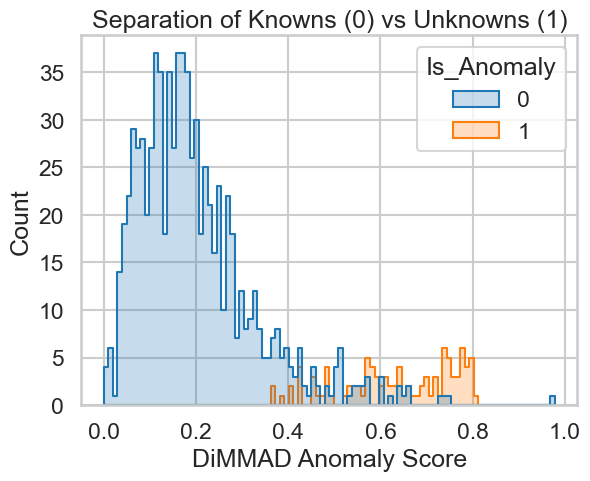

In [17]:
plt.figure()

sns.histplot(
    data=results,
    x="Anomaly_Score",
    hue="Is_Anomaly",
    element="step",
    common_norm=False,
    bins=100,
    palette={0: "tab:blue", 1: "tab:orange"},
)

plt.xlabel("DiMMAD Anomaly Score")
plt.title("Separation of Knowns (0) vs Unknowns (1)")
plt.show()

### 5.3. If we have a limited "budget", how well do we do?

In [18]:
budget = 50
top_candidates = results.head(budget)
purity = top_candidates["Is_Anomaly"].mean()

print(f"Budget: {budget} observations")
print(f"True Discoveries (QSO/AGN): {top_candidates['Is_Anomaly'].sum()}")
print(f"Purity: {purity:.1%}")

Budget: 50 observations
True Discoveries (QSO/AGN): 45
Purity: 90.0%
